# Project In Data Science 
## Stroke Prediction (EDA - ML experimentation)
### Author: Ioannis Stathakis

###

## Part 2: Data Analysis (EDA) and Feature Selection
### In this part we will further explore the dataset.
### 1. Exlore characteristics and distributions
### 2. Investigate possible correlations between variables and/or the target
### 3. Take further processing actions (deal with outliers, feature engineering, etc)
### 4. Final preparation steps for the model experimentation phase

In [2]:
# Importing necessary libraries
import warnings
warnings.filterwarnings("ignore") # To ignore some reccuring system warnings of no importance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import Lasso

In [2]:
# Lets use the cleaned dataset from Part 1 and import the data
main_df = pd.read_csv("cleaned_stroke_data.csv", header=[0])
main_df.head()

,Gender,Age,Hypertension,Heart_Disease,Ever_Married,Work_Type,Residence_Type,Avg_Glucose_Level,BMI,Smoking_Status,Stroke,Age_Group
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,Senior Adult
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,29.2,never smoked,1,Senior Adult
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,Senior Adult
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,Middle Aged Adult
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,Senior Adult


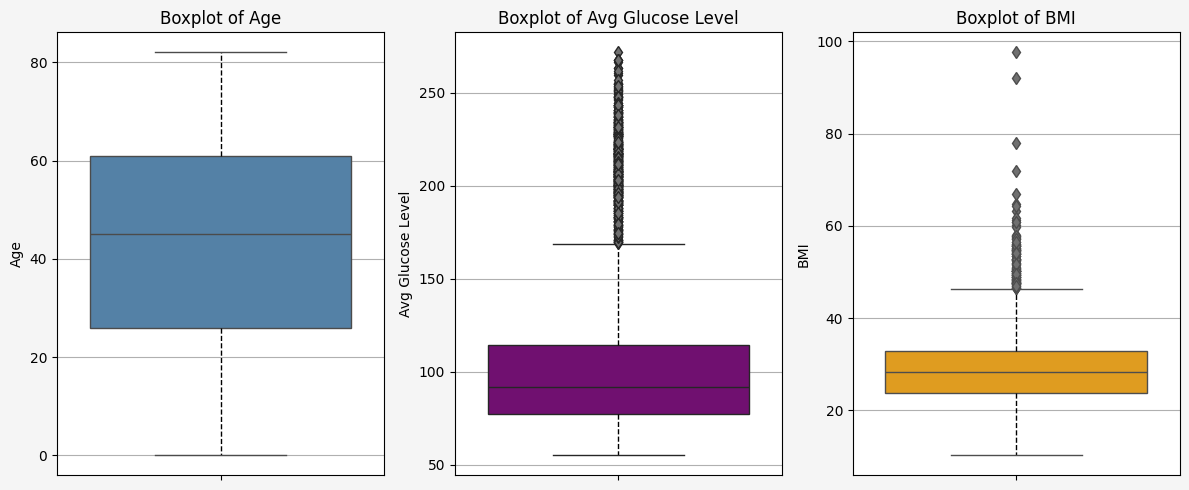

In [3]:
# Lets start by checking the non-binary numerical columns for outliers 
# Secifically BMI, Age and Avg_Glucose_Level

# Lets examine these variables with Boxplots in the same graph
plt.figure(figsize=(12, 5), facecolor="whitesmoke")

# Boxplot for Age
plt.subplot(1, 3, 1)
sns.boxplot(y=main_df["Age"], color="steelblue", zorder=2,
            flierprops=dict(markerfacecolor="#707070", marker="d"),
            whiskerprops=dict(color="black", linestyle="--"))
plt.title("Boxplot of Age")
plt.ylabel("Age")
plt.grid(axis="y", zorder=0)

# Boxplot for Avg_Gluckose_Level
plt.subplot(1, 3, 2)
sns.boxplot(y=main_df["Avg_Glucose_Level"], color="purple",
            zorder=2, flierprops=dict(markerfacecolor="#707070", marker="d"),
            whiskerprops=dict(color="black", linestyle="--"))
plt.title("Boxplot of Avg Glucose Level")
plt.ylabel("Avg Glucose Level")
plt.grid(axis="y", zorder=0)

# Boxplot for BMI
plt.subplot(1, 3, 3)
sns.boxplot(y=main_df["BMI"], color="orange", zorder=2,
            flierprops=dict(markerfacecolor="#707070", marker="d"),
            whiskerprops=dict(color="black", linestyle="--"))
plt.title("Boxplot of BMI")
plt.ylabel("BMI")
plt.grid(axis="y", zorder=0)

# Show plots
plt.tight_layout()
plt.show()

In [4]:
# We can see that there indeed seem to be quite a lot of outliers in the Avg_Glucose_Level and BMI variables
# Lets further examine with IQR analysis like we did for the BMI in the different Age Groups feature (in Part 1):

# Calculate Q1, Q3, and IQR for Avg_Glucose_Level
glucose_IQR = main_df["Avg_Glucose_Level"].quantile([0.25, 0.75])
Q1, Q3 = glucose_IQR[0.25], glucose_IQR[0.75]
IQR = Q3 - Q1

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count the number of outliers
outliers = main_df[(main_df["Avg_Glucose_Level"] < lower_bound) | 
                   (main_df["Avg_Glucose_Level"] > upper_bound)]
outlier_count = outliers.shape[0]

# Calculate the percentage of outliers
total_entries = main_df.shape[0]
outlier_percentage = (outlier_count / total_entries) * 100

# Create a summary DataFrame
glucose_outlier_summary = pd.DataFrame({
    "Q1 (25%)": [Q1],
    "Q3 (75%)": [Q3],
    "IQR": [IQR],
    "Lower Bound": [lower_bound],
    "Upper Bound": [upper_bound],
    "Outlier Count": [outlier_count],
    "Total Entries": [total_entries],
    "Outlier Percentage": [outlier_percentage]
})

# Display the results
glucose_outlier_summary


,Q1 (25%),Q3 (75%),IQR,Lower Bound,Upper Bound,Outlier Count,Total Entries,Outlier Percentage
0,77.235,114.09,36.855,21.9525,169.3725,627,5087,12.325536


In [5]:
# Lets also examine the BMI feature with the IQR approach, this time without considering the various Age Groups

# Calculate Q1, Q3, and IQR for BMI
bmi_IQR = main_df["BMI"].quantile([0.25, 0.75])
Q1, Q3 = bmi_IQR[0.25], bmi_IQR[0.75]
IQR = Q3 - Q1

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count the number of outliers
outliers = main_df[(main_df["BMI"] < lower_bound) | 
                   (main_df["BMI"] > upper_bound)]
outlier_count = outliers.shape[0]

# Calculate the percentage of outliers
total_entries = main_df.shape[0]
outlier_percentage = (outlier_count / total_entries) * 100

# Create a summary DataFrame
bmi_outlier_summary = pd.DataFrame({
    "Q1 (25%)": [Q1],
    "Q3 (75%)": [Q3],
    "IQR": [IQR],
    "Lower Bound": [lower_bound],
    "Upper Bound": [upper_bound],
    "Outlier Count": [outlier_count],
    "Total Entries": [total_entries],
    "Outlier Percentage": [outlier_percentage]
})

# Display the results
bmi_outlier_summary

,Q1 (25%),Q3 (75%),IQR,Lower Bound,Upper Bound,Outlier Count,Total Entries,Outlier Percentage
0,23.7,32.8,9.1,10.05,46.45,123,5087,2.417928


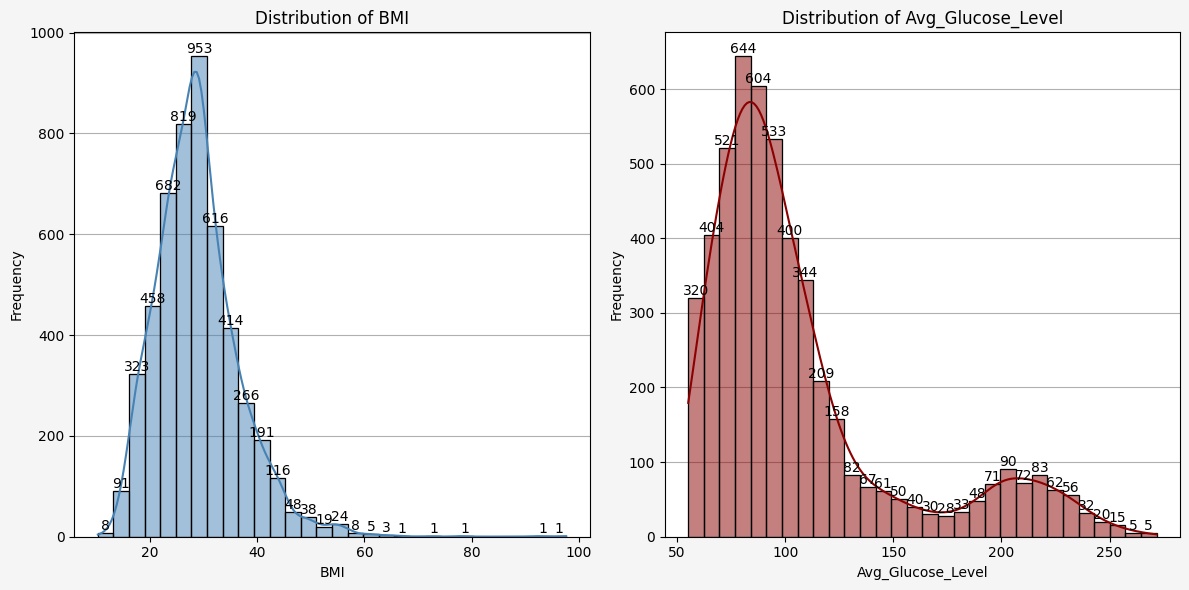

In [6]:
# LEts also check out the distribution of these two features, in a couple of histograms
# I will do this in order to observe whether the distributions are greatly skewed because of the outliers
# If this is the case, it will mean that our models might be affected in the training phase
# So this step is necessary for the final decision on how to handle the outliers in these two variables
# I will add Kernel Density Estimation so that we can visualize the distributions more consicely

# this is a short function in order to add count labels on the histogram bars
def add_counts(ax):
    for patch in ax.patches:
        height = patch.get_height()
        if height > 0:  # Avoid labeling zero-height bars
            ax.annotate(f"{int(height)}", (patch.get_x() + patch.get_width() / 2, height), ha='center', va='bottom', fontsize=10, color='black')
            
# Set the figure characteristics:
plt.figure(figsize=(12,6), facecolor="whitesmoke")

# Histogram for the BMI variable
plt.subplot(1, 2, 1)
ax1 = sns.histplot(main_df["BMI"], bins=30, kde=True, color="steelblue", zorder=2)
plt.title("Distribution of BMI", size=12)
plt.xlabel("BMI", size=10)
plt.ylabel("Frequency", size=10)
plt.grid(axis="y", zorder=0)
add_counts(ax1)

# Histogram for the Avg_Glucose_Level variable
plt.subplot(1, 2, 2)
ax2 = sns.histplot(main_df["Avg_Glucose_Level"], bins=30, kde=True, color="darkred", zorder=2)
plt.title("Distribution of Avg_Glucose_Level", size=12)
plt.xlabel("Avg_Glucose_Level", size=10)
plt.ylabel("Frequency", size=10)
plt.grid(axis="y", zorder=0)
add_counts(ax2)

# Show the plots and adjust the layout
plt.tight_layout()
plt.show()

### BMI distribution shows a little positive skeweness, while Avg_Glucose_Level is heavily skewed.
### As far as the BMI is concerned, the best approach is to probably keep all the outliers, for three main reasons:
### 1) The outlier percentage is very small (about 2.4%)
### 2) The skewness caused from the outliers is minimal
### 3) The BMI index is known to be of medical importance to stroke condition
### Retaining variability for some models in the training phase to come, might also be another reason for this approach.

###

### The strong skewness of the Avg_Glucose_Level variable however, is another matter.
### Outlier percentage is not extremely high (about 12.3%).
### How ever the existence of bimodality, possible non-normality, and also medical importance of the variable, must all be taken into account.
### We need to test for normality and bimodality more specifically, so we can decide what to do with the outliers.

In [7]:
# to do this, I will test Normality with three approaches:
# Shapiro-Wilk test, Anderson-Darling test and QQ-plot for a more visual approach
# After these, we will also test for bimodality using the bimodality coefficient

# Perform Shapiro-Wilk test (standard prcedure is to resample 500 data points for this test, since our dataset is relatively large)
shapiro_test = stats.shapiro(main_df["Avg_Glucose_Level"].sample(500))

# Print results (test-statistic and p-value)
print(f"Shapiro-Wilk Test Statistic: {shapiro_test.statistic:.4f}, p-value: {shapiro_test.pvalue:.4f}")

# Interpretation depending on the returned p-value (using standard level of significance a=0.05):
if shapiro_test.pvalue < 0.05:
    print("The data is NOT normally distributed (reject null hypothesis).")
else:
    print("The data is normally distributed (fail to reject null hypothesis).")


Shapiro-Wilk Test Statistic: 0.8051, p-value: 0.0000
The data is NOT normally distributed (reject null hypothesis).


In [8]:
# Lets now try the Anderson-Darling test, admittedly more suitable for large datasets than the Shapiro-Wilk
anderson_test = stats.anderson(main_df["Avg_Glucose_Level"], dist='norm')

# Print results (test statistics and corresponding p-values)
print("Anderson-Darling Test Statistic:", anderson_test.statistic)
print("Critical Values:", anderson_test.critical_values)
print("Significance Levels:", anderson_test.significance_level)

# Interpretation (for many different significance levels which the test conveniently returns):
for i in range(len(anderson_test.critical_values)):
    if anderson_test.statistic > anderson_test.critical_values[i]:
        print(f"The data is NOT normally distributed at {anderson_test.significance_level[i]}% significance level.")
    else:
        print(f"The data is normally distributed at {anderson_test.significance_level[i]}% significance level.")


Anderson-Darling Test Statistic: 351.7385065243552
Critical Values: [0.576 0.655 0.786 0.917 1.091]
Significance Levels: [15.  10.   5.   2.5  1. ]
The data is NOT normally distributed at 15.0% significance level.
The data is NOT normally distributed at 10.0% significance level.
The data is NOT normally distributed at 5.0% significance level.
The data is NOT normally distributed at 2.5% significance level.
The data is NOT normally distributed at 1.0% significance level.


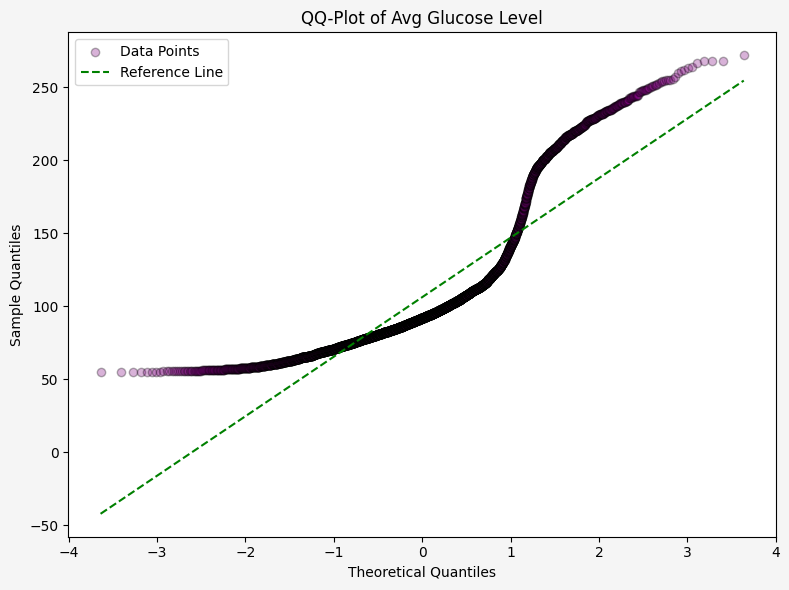

In [9]:
# Now I will generate QQ-plot to better visualize the results
# QQ-Plot for Avg_Glucose_Level
plt.figure(figsize=(8,6), facecolor="whitesmoke")
res = stats.probplot(main_df["Avg_Glucose_Level"], dist="norm")
# Scatter points and line customizations:
plt.scatter(res[0][0], res[0][1], color="purple", alpha=0.3, label="Data Points", edgecolor="black") 
plt.plot(res[0][0], res[1][0] * res[0][0] + res[1][1], color="green", linestyle="--", label="Reference Line")  
plt.title("QQ-Plot of Avg Glucose Level")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.legend()

# Show plots
plt.tight_layout()
plt.show()


### The Avg_Glucose_Level is far from normal
### Lets test for bimodality (which is also evident from the QQ-plot)

In [10]:
# Lets examine the bimodality a bit deeper
# A Bimodality Coefficient above 0.55 suggests bimodal or multimodal distribution
# This will reinforce the presence of two distinct groups in the Avg_Glucose_Level variable

# A simple function to calculate the Bimodality Coefficient:
def bimodality_coefficient(data):
    n = len(data)
    skewness = stats.skew(data)
    kurtosis = stats.kurtosis(data, fisher=True)  # Fisher=True gives excess kurtosis
    return (skewness**2 + 1) / (kurtosis + (3 * (n - 1)**2) / ((n - 2) * (n - 3)))

# Compute Bimodality Coefficient for Avg_Glucose_Level
bimodality_coeff = bimodality_coefficient(main_df["Avg_Glucose_Level"].dropna())

# Print results
print(f"Bimodality Coefficient: {bimodality_coeff:.4f}")

# Interpretation:
if bimodality_coeff > 0.55:
    print("The data is likely bimodal or multimodal.")
else:
    print("The data is likely unimodal.")


Bimodality Coefficient: 0.7424
The data is likely bimodal or multimodal.


###

### So it is very obvious that the Avg_Glucose_Level variable is non-normal and also bimodal. Since Avg_Glucose_Level is bimodal, this suggests that there may be two distinct subpopulations within our dataset (for example diabetics versus non-diabetics). 
### Before deciding on how to handle the outliers, we can analyze these groups separately to try and understand what causes the bimodality.

In [11]:
# The first idea is to use a GMM (Gaussian Mixture Model) to try and identify the two separate groups
# We can then compare the characteristics of these two groups (stroke occurence, BMI range, etc)
# Using some more robust statistical tests would be a good idea too

# Reshape glucose levels for GMM
glucose_values = main_df["Avg_Glucose_Level"].values.reshape(-1, 1)

# Fit GMM with 2 components (since we are assuming bimodality)
gmm = GaussianMixture(n_components=2, random_state=42)
main_df["Glucose_Group"] = gmm.fit_predict(glucose_values)

# Check distribution of groups
print(main_df["Glucose_Group"].value_counts())


Glucose_Group
0    4288
1     799
Name: count, dtype: int64


In [12]:
# Replace 0s and 1s with distinct categories for easier interpretation
main_df["Glucose_Group"] = main_df["Glucose_Group"].replace({0: "Lower", 1: "Higher"}).astype("category")
main_df["Glucose_Group"].value_counts()

Glucose_Group
Lower     4288
Higher     799
Name: count, dtype: int64

###

In [13]:
# I will also perform the same transformation for the other two binary columns, for now
binary_columns = ["Hypertension", "Heart_Disease"]

# Convert 0 → "No" and 1 → "Yes" while changing to categorical type
for col in binary_columns:
    main_df[col] = main_df[col].replace({0: "No", 1: "Yes"}).astype("category")


###

### Lets start with some simple comparisons, and then move to more specific statistical tests between the two groups.

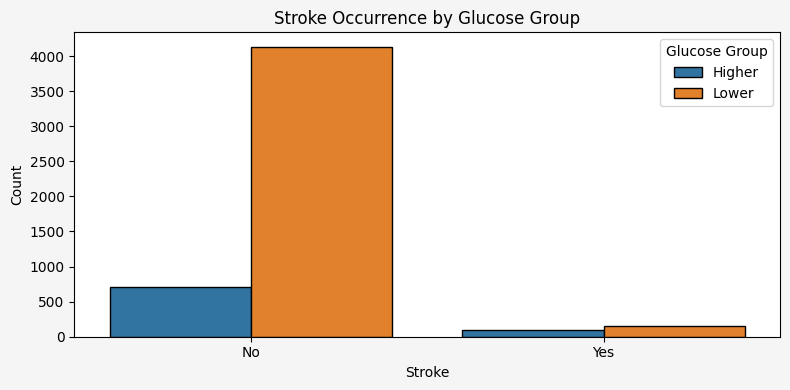

In [14]:
# Lets create a simple countplot comparing the two Glucose groups as far as stroke occurence goes:
plt.figure(figsize=(8, 4), facecolor="whitesmoke")
ax = sns.countplot(data=main_df, x="Stroke", hue="Glucose_Group", edgecolor="black")
plt.title("Stroke Occurrence by Glucose Group")
plt.xlabel("Stroke")
plt.ylabel("Count")
plt.legend(title="Glucose Group")
ax.set_xticks(ticks=(0,1), labels=["No", "Yes"])
plt.tight_layout()
plt.show()


### We see that the presence of higher-glucose cases is more evident in the group that had stroke occurence.

###

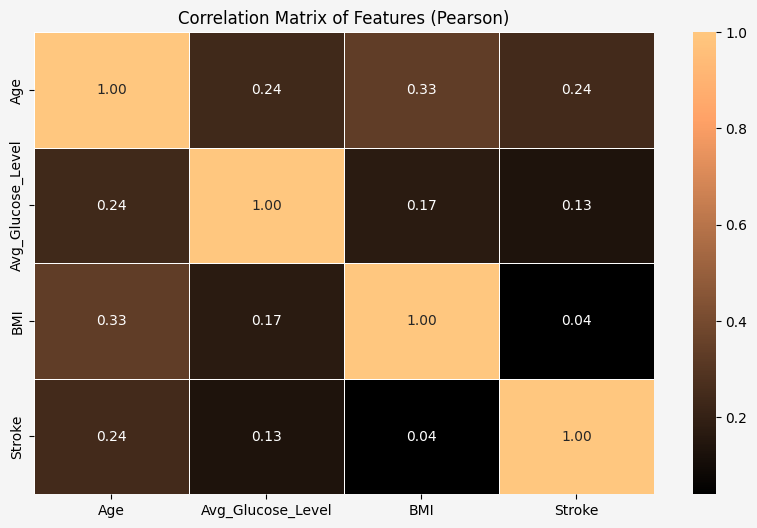

In [15]:
# Compute correlation matrix for the non-categorical variables
# Use two approaches: Pearson and Spearman-rank correlations

# Lets start with Pearson:
correlation_matrix = main_df.corr(method="pearson", numeric_only=True)

# Plot heatmap
plt.figure(figsize=(10, 6), facecolor="whitesmoke")
sns.heatmap(correlation_matrix, annot=True, cmap="copper", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Features (Pearson)")
plt.show()

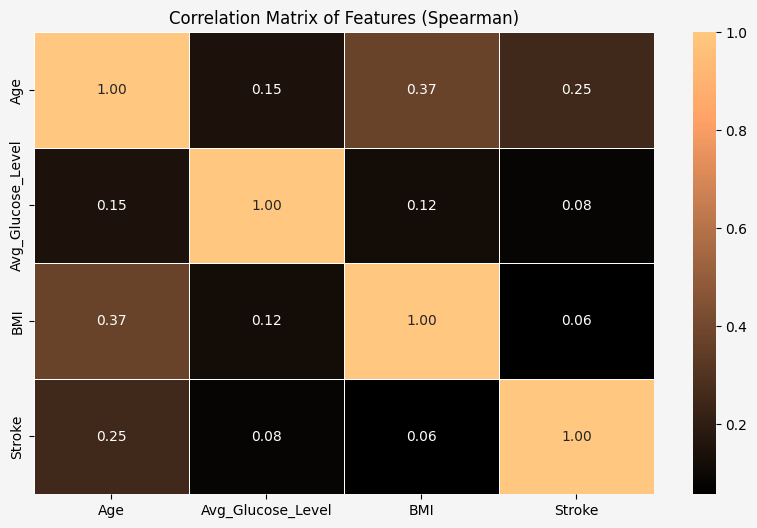

In [16]:
# Lets continue with Spearman-rank:
correlation_matrix = main_df.corr(method="spearman", numeric_only=True)

# Plot heatmap
plt.figure(figsize=(10, 6), facecolor="whitesmoke")
sns.heatmap(correlation_matrix, annot=True, cmap="copper", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Features (Spearman)")
plt.show()

###

### We can observe some moderate correlations between some of the features.
### For example BMI with Age (as expected), Stroke with Age as well.
### We will investigate more specifically  for some of these.

In [17]:
# A quick check: summary statistics (means) for the three key numerical features across both GLucose groups
cols = ["Age", "BMI", "Avg_Glucose_Level"]

for col in cols:
    group_comparison = main_df.groupby("Glucose_Group")[col].mean()
    print(f"Means across Glucose Groups for {col} are:")
    print(group_comparison, "\n")


Means across Glucose Groups for Age are:
Glucose_Group
Higher    56.371865
Lower     40.919981
Name: Age, dtype: float64 

Means across Glucose Groups for BMI are:
Glucose_Group
Higher    31.987860
Lower     28.309258
Name: BMI, dtype: float64 

Means across Glucose Groups for Avg_Glucose_Level are:
Glucose_Group
Higher    198.859212
Lower      88.915543
Name: Avg_Glucose_Level, dtype: float64 



###

### Of course, using targeted statistical tests (like t-tests) would be more robust than just comparing means. 
### Since we want to investigate whether the two glucose groups represent different populations, running formal hypothesis tests will help us validate whether they differ significantly in key variables like stroke occurrence, age, BMI, hypertension, etc.

In [18]:
# Lets start with some t-tests for these characteristics between the two groups
# T-test has some assumptions which need to be met, in order for the test to be considered accurate
# Groups should be independent and show homogeneity of variances 
# Data should also be normally distributed in each group (this can be relaxed for large samples due to the Central Limit Theorem).
# The lack of homoscedasticity can be handled by using the more appropriate Welch's T-Test

# Split dataset into two groups based on Glucose_Group
group_0 = main_df[main_df["Glucose_Group"] == "Lower"]
group_1 = main_df[main_df["Glucose_Group"] == "Higher"]

# Perform t-tests for continuous variables
for feature in ["Age", "BMI", "Avg_Glucose_Level"]:
    t_stat, p_value = stats.ttest_ind(group_0[feature], group_1[feature], equal_var=False)  # Welch's T-test
    print(f"T-test for {feature}: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")


T-test for Age: t-statistic = -20.4170, p-value = 0.0000
T-test for BMI: t-statistic = -12.3653, p-value = 0.0000
T-test for Avg_Glucose_Level: t-statistic = -98.7507, p-value = 0.0000


In [19]:
# The t-test for the Avg_Glucose_Level shows statistically significant results, but we know this variable is not Normally distributed
# In this case, the more suitable non-parametric alternative is the Mann-Whitney U test
# Lets also perform this test to better verify the results for this particular variable

# Perform Mann-Whitney U test for Avg_Glucose_Level
u_stat, p_value = stats.mannwhitneyu(group_0["Avg_Glucose_Level"], group_1["Avg_Glucose_Level"], alternative="two-sided")

print(f"Mann-Whitney U Test for Avg_Glucose_Level: U-statistic = {u_stat:.4f}, p-value = {p_value:.4f}")


Mann-Whitney U Test for Avg_Glucose_Level: U-statistic = 0.0000, p-value = 0.0000


###

### So this is the first robust indication that Age, BMI, and Avg_Glucose_Level actually differ in a statistically significant way between the two Glucose groups.
### Lets also check out some of the categorical variables. We will do this using the Chi-Squared Test for Independence.
### I will use the Chi-Squared to compare Stroke occurrence, Hypertension, Heart Disease.

In [20]:
# The Chi-Square Test for Independence has some necessary assumptions
# The most important is that all observations must be >5
# If one category (for example stroke = 1) has very few occurrences, the test might become unstable or unreliable due to small expected counts
# We can test this prerequisite:

# Create contingency table
contingency_table = pd.crosstab(main_df["Glucose_Group"], main_df["Stroke"])

# Check expected frequencies
expected_counts = stats.contingency.expected_freq(contingency_table)
print(expected_counts)  # If any value <5, we should switch to Fisher's Exact Test

[[ 759.89030863   39.10969137]
 [4078.10969137  209.89030863]]


In [21]:
# Define categorical variables to test
categorical_vars = ["Stroke", "Hypertension", "Heart_Disease"]

# Perform chi-square tests
for var in categorical_vars:
    contingency_table = pd.crosstab(main_df["Glucose_Group"], main_df[var])
    chi2_stat, p_value, _, _ = stats.chi2_contingency(contingency_table)
    print(f"Chi-Square Test for {var}: chi2-statistic = {chi2_stat:.4f}, p-value = {p_value:.4f}")


Chi-Square Test for Stroke: chi2-statistic = 87.5428, p-value = 0.0000
Chi-Square Test for Hypertension: chi2-statistic = 165.7163, p-value = 0.0000
Chi-Square Test for Heart_Disease: chi2-statistic = 130.4742, p-value = 0.0000


### The categorical variables also seem to differ in a significant way, across the twop glucose groups.
### Considering these findings, I believe that the best course of action is to leave the Avg_Glucose_Level outliers as they are.
### This will ensure the retention of the seemingly important bimodality of the feature, and also the relationships with the other features.
### Removing these outliers could also erase meaningful medical patterns.
### If at the later stage, we face model struggle with the outliers, we can try robust models like Random Forests, which handle extreme values well.

###

### Lets explore the dataset and see what more we can learn from the data, before we get to the modelling phase

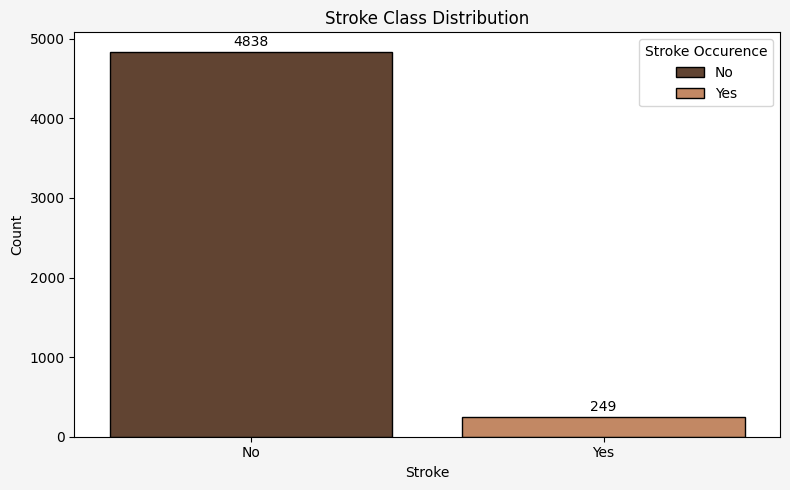

Stroke Class Distribution:
 Stroke
0    95.10517
1     4.89483
Name: proportion, dtype: float64


In [22]:
# Lets start with visually checking out the stroke class imbalance
# Count plot of stroke occurrences
plt.figure(figsize=(8, 5), facecolor="whitesmoke")
ax = sns.countplot(data=main_df, x="Stroke", palette="copper", edgecolor="black")
plt.title("Stroke Class Distribution")
plt.xlabel("Stroke")
plt.ylabel("Count")
plt.tight_layout()

# Include the count labels for every bar
for x in ax.containers:
    ax.bar_label(x, label_type="edge", padding=2)

ax.set_xticks(ticks=(0,1), labels=["No", "Yes"])
plt.legend(title="Stroke Occurence", labels=["No", "Yes"])
plt.show()

# Print percentage of each class
stroke_distribution = main_df["Stroke"].value_counts(normalize=True) * 100
print("Stroke Class Distribution:\n", stroke_distribution)


### The class is extremely imbalanced, so we are going to use SMOTE when we get to the training phase

###

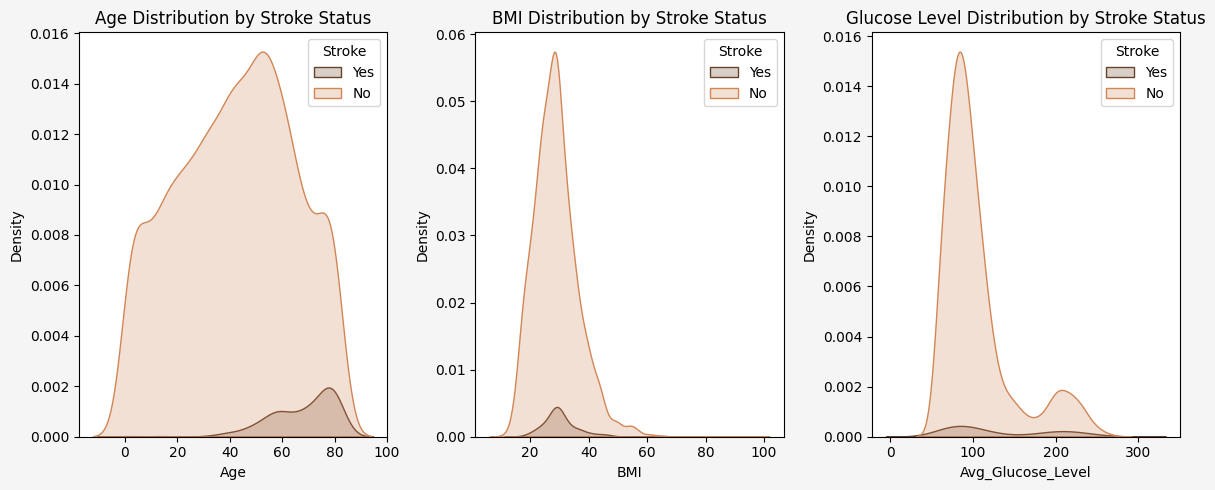

In [23]:
# lets check out the distribution of some of the features, across the stroke occurence target
# I will first focus on the basic numerical features ("Age", "BMI", "Avg_Glucose_Level")

# Set figure size
plt.figure(figsize=(12, 5), facecolor="whitesmoke")

# Histogram for Age by Stroke Status
plt.subplot(1, 3, 1)
sns.kdeplot(data=main_df, x="Age", hue="Stroke", fill=True, palette="copper_r")
plt.title("Age Distribution by Stroke Status")
plt.legend(title="Stroke", labels=["Yes", "No"])

# Histogram for BMI by Stroke Status
plt.subplot(1, 3, 2)
sns.kdeplot(data=main_df, x="BMI", hue="Stroke", fill=True, palette="copper_r")
plt.title("BMI Distribution by Stroke Status")
plt.legend(title="Stroke", labels=["Yes", "No"])

# Histogram for Avg_Glucose_Level by Stroke Status
plt.subplot(1, 3, 3)
sns.kdeplot(data=main_df, x="Avg_Glucose_Level", hue="Stroke", fill=True, palette="copper_r")
plt.title("Glucose Level Distribution by Stroke Status")
plt.legend(title="Stroke", labels=["Yes", "No"])

plt.tight_layout()
plt.show()


### There are some details to notice here, for example we can observe that the Age variable is differently distributed across stroke/no-stroke classes.
### I will use some more targeted tests to see if there are statistical significances here.

In [24]:
# First, I will create a new column with the main BMI categories
# This might help with the analysis and the testing a bit later

# Function to categorize BMI
def categorize_bmi(bmi):
    if bmi < 18.5:
        return "Underweight"
    elif bmi < 25:
        return "Normal"
    elif bmi < 30:
        return "Overweight"
    else:
        return "Obese"

# Apply BMI categorization
main_df["BMI_Category"] = main_df["BMI"].apply(categorize_bmi)
main_df.head()

,Gender,Age,Hypertension,Heart_Disease,Ever_Married,Work_Type,Residence_Type,Avg_Glucose_Level,BMI,Smoking_Status,Stroke,Age_Group,Glucose_Group,BMI_Category
0,Male,67.0,No,Yes,Yes,Private,Urban,228.69,36.6,formerly smoked,1,Senior Adult,Higher,Obese
1,Female,61.0,No,No,Yes,Self-employed,Rural,202.21,29.2,never smoked,1,Senior Adult,Higher,Overweight
2,Male,80.0,No,Yes,Yes,Private,Rural,105.92,32.5,never smoked,1,Senior Adult,Lower,Obese
3,Female,49.0,No,No,Yes,Private,Urban,171.23,34.4,smokes,1,Middle Aged Adult,Higher,Obese
4,Female,79.0,Yes,No,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,Senior Adult,Higher,Normal


### 

### I will use the following approach:
### 1) Test the Age and BMI variables for normality, using the Anderson-Darling Test and QQ-plotting.
### 2) If variables are normal, I will test for significant differences of stroke/no-stroke subclasses, using the T-Test.
### 3) If variables are not normal, then I will use the Mann-Whitney U Test, as it is the non-parametric equivalent of the T-Test.
### 4) Lastly, I will also use a Chi-Squared Test on the categorical "BMI_Category" variable, for extra information.

In [25]:
# Lets start with the Anderson-Darling test, for the Normality of the "Age" variable
anderson_test = stats.anderson(main_df["Age"], dist='norm')

# Print results (test statistics and corresponding p-values)
print("Anderson-Darling Test Statistic:", anderson_test.statistic)
print("Critical Values:", anderson_test.critical_values)
print("Significance Levels:", anderson_test.significance_level)

# Interpretation (for many different significance levels which the test conveniently returns):
for i in range(len(anderson_test.critical_values)):
    if anderson_test.statistic > anderson_test.critical_values[i]:
        print(f"The data is NOT normally distributed at {anderson_test.significance_level[i]}% significance level.")
    else:
        print(f"The data is normally distributed at {anderson_test.significance_level[i]}% significance level.")

Anderson-Darling Test Statistic: 33.301752971977294
Critical Values: [0.576 0.655 0.786 0.917 1.091]
Significance Levels: [15.  10.   5.   2.5  1. ]
The data is NOT normally distributed at 15.0% significance level.
The data is NOT normally distributed at 10.0% significance level.
The data is NOT normally distributed at 5.0% significance level.
The data is NOT normally distributed at 2.5% significance level.
The data is NOT normally distributed at 1.0% significance level.


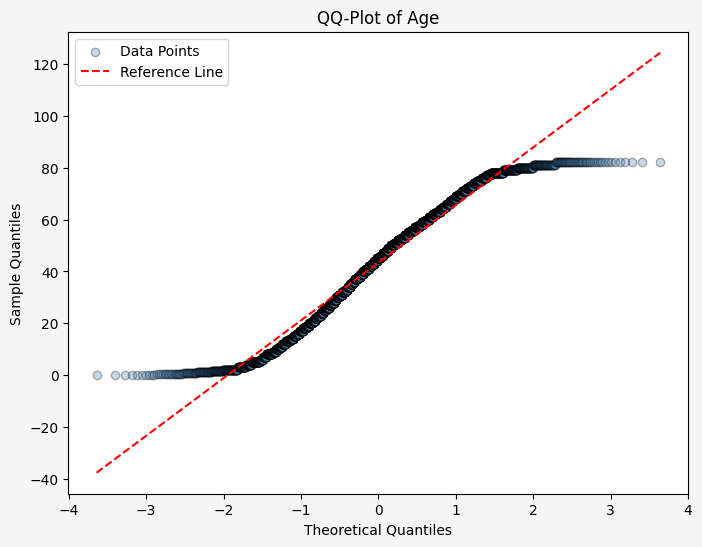

In [26]:
# Lets visualize the apparent non-linearity of the Age variable with a QQ-plot 
# Set figure characteristics
plt.figure(figsize=(8,6), facecolor="whitesmoke")

# QQ-Plot for BMI
res = stats.probplot(main_df["Age"], dist="norm")
# Scatter points and line customizations:
plt.scatter(res[0][0], res[0][1], color="steelblue", alpha=0.3, label="Data Points", edgecolor="black")  
plt.plot(res[0][0], res[1][0] * res[0][0] + res[1][1], color="red", linestyle="--", label="Reference Line")  
plt.title("QQ-Plot of Age")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.legend()
plt.show()

In [27]:
# Lets try the Anderson-Darling test, for the Normality of the "BMI" variable
anderson_test = stats.anderson(main_df["BMI"], dist='norm')

# Print results (test statistics and corresponding p-values)
print("Anderson-Darling Test Statistic:", anderson_test.statistic)
print("Critical Values:", anderson_test.critical_values)
print("Significance Levels:", anderson_test.significance_level)

# Interpretation (for many different significance levels which the test conveniently returns):
for i in range(len(anderson_test.critical_values)):
    if anderson_test.statistic > anderson_test.critical_values[i]:
        print(f"The data is NOT normally distributed at {anderson_test.significance_level[i]}% significance level.")
    else:
        print(f"The data is normally distributed at {anderson_test.significance_level[i]}% significance level.")

Anderson-Darling Test Statistic: 34.90433319031399
Critical Values: [0.576 0.655 0.786 0.917 1.091]
Significance Levels: [15.  10.   5.   2.5  1. ]
The data is NOT normally distributed at 15.0% significance level.
The data is NOT normally distributed at 10.0% significance level.
The data is NOT normally distributed at 5.0% significance level.
The data is NOT normally distributed at 2.5% significance level.
The data is NOT normally distributed at 1.0% significance level.


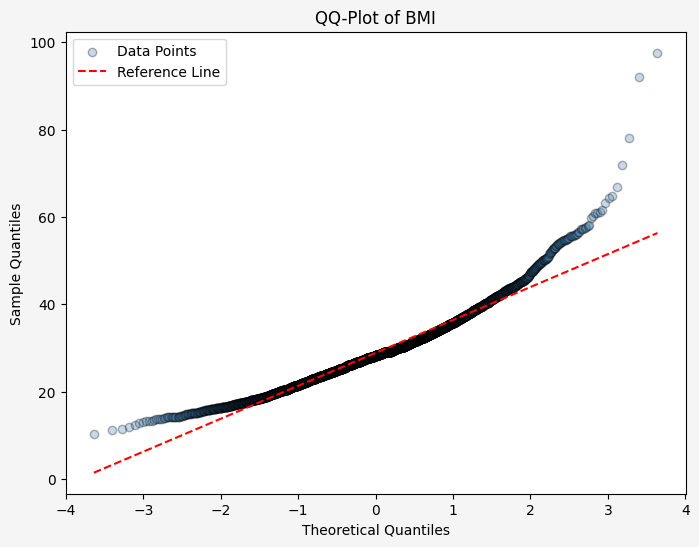

In [28]:
# Lets visualize the apparent non-linearity of the BMI variable with a QQ-plot 
# Set figure characteristics
plt.figure(figsize=(8,6), facecolor="whitesmoke")

# QQ-Plot for BMI
res = stats.probplot(main_df["BMI"], dist="norm")
# Scatter points and line customizations:
plt.scatter(res[0][0], res[0][1], color="steelblue", alpha=0.3, label="Data Points", edgecolor="black")  
plt.plot(res[0][0], res[1][0] * res[0][0] + res[1][1], color="red", linestyle="--", label="Reference Line")  
plt.title("QQ-Plot of BMI")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.legend()
plt.show()

### So we see that both Age and BMI seem not to be normally distributed.
### Therefore, we will use the Mann-Whitney U Test for both.

In [29]:
# Perform Mann-Whitney U test for Age
u_stat, p_value = stats.mannwhitneyu(main_df[main_df["Stroke"] == 1]["Age"],
                               main_df[main_df["Stroke"] == 0]["Age"],
                               alternative="two-sided")

print(f"Mann-Whitney U Test for Age: U-Statistic = {u_stat:.4f}, P-Value = {p_value:.4f}")
if p_value < 0.05:
    print("   → Significant difference in Age between Stroke groups.")
else:
    print("   → No significant difference in Age between Stroke groups.")


Mann-Whitney U Test for Age: U-Statistic = 1004440.0000, P-Value = 0.0000
   → Significant difference in Age between Stroke groups.


In [30]:
# Perform Mann-Whitney U test for BMI
u_stat, p_value = stats.mannwhitneyu(main_df[main_df["Stroke"] == 1]["BMI"],
                               main_df[main_df["Stroke"] == 0]["BMI"],
                               alternative="two-sided")

print(f"Mann-Whitney U Test for BMI: U-Statistic = {u_stat:.4f}, P-Value = {p_value:.4f}")
if p_value < 0.05:
    print("   → Significant difference in BMI between Stroke groups.")
else:
    print("   → No significant difference in BMI between Stroke groups.")


Mann-Whitney U Test for BMI: U-Statistic = 694689.0000, P-Value = 0.0000
   → Significant difference in BMI between Stroke groups.


### Wee observe significant differences in stroke occurence groups, both for the Age and the BMI features.
### Lets finish this up with a Chi-Squared Test for the categorized BMI variable.

In [31]:
# Create contingency table
contingency_table = pd.crosstab(main_df["Stroke"], main_df["BMI_Category"])

# Perform Chi-Square Test
chi2_stat, p_value, _, _ = stats.chi2_contingency(contingency_table)

print(f"Chi-Square Test for BMI Categories: Chi2-Statistic = {chi2_stat:.4f}, P-Value = {p_value:.4f}")
if p_value < 0.05:
    print("   → Significant difference in BMI Categories between Stroke groups.")
else:
    print("   → No significant difference in BMI Categories between Stroke groups.")


Chi-Square Test for BMI Categories: Chi2-Statistic = 40.6826, P-Value = 0.0000
   → Significant difference in BMI Categories between Stroke groups.


### The results are as expected.

###

### So now we have finished with the exploration of the numerical features, and obtained some interesting results.
### Before we can conclude our findings and move on to the modelling phase, we need to explore the categorical/binary variables as well.
### As before, I will start with some visual exploratory analysis, and move on to more robust statistical testing.

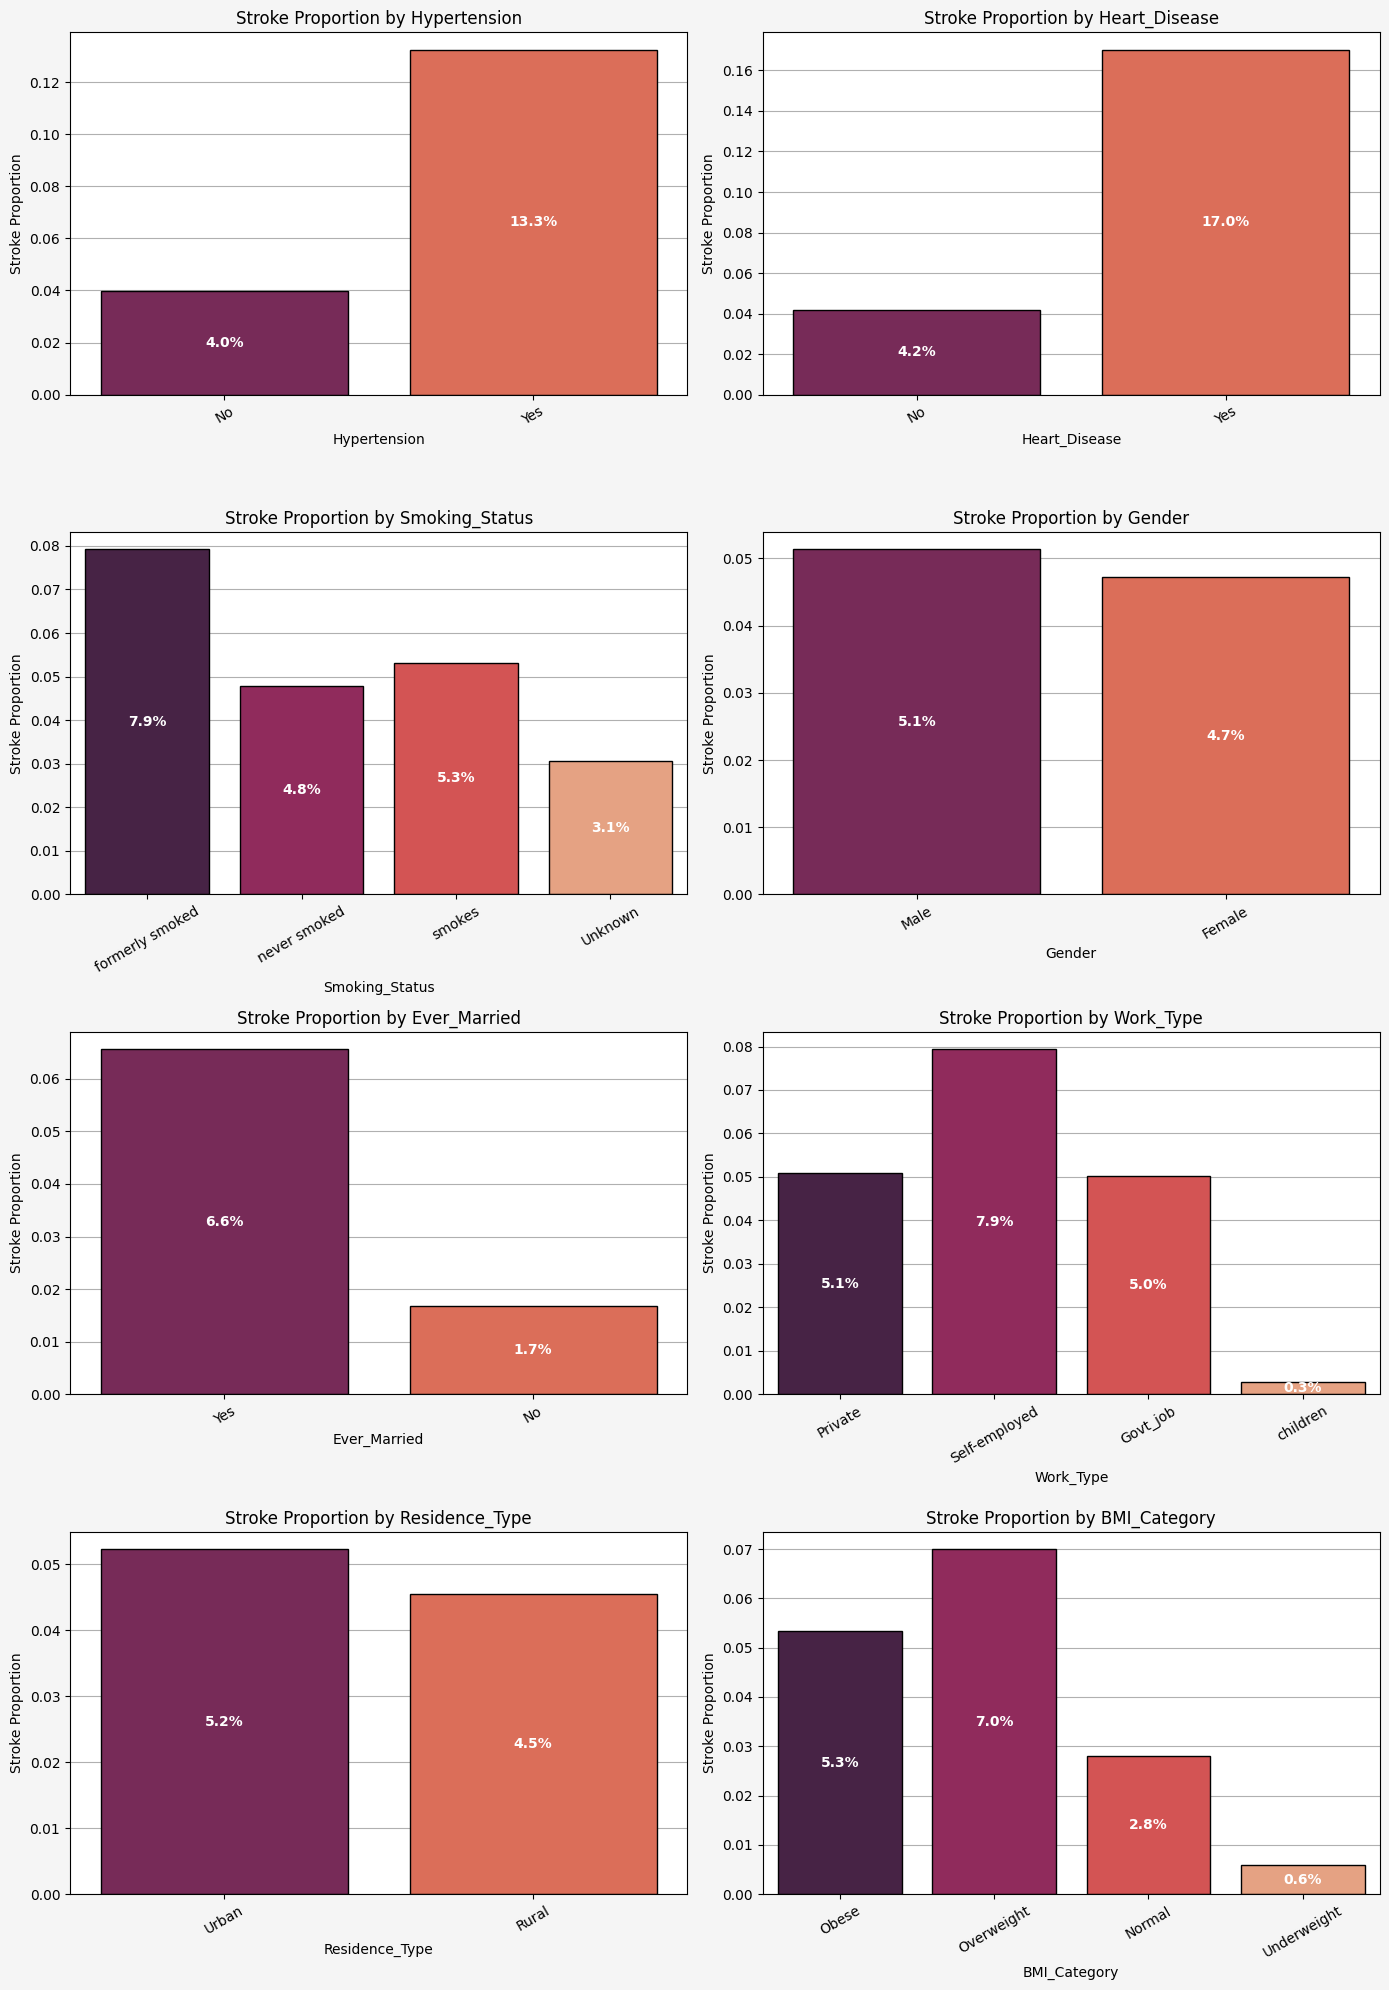

In [32]:
# We can now try to visualize the percentage of stroke occurence in each subclass of our categorical values
# This will provide some first clues as to whether there might by reason to search even deeper, in some of these variables
# If the percentages across the subcategories in each variable, are roughly the same for stroke/no-stroke, the variable might not be a good predictor
# List of categorical variables to test
categorical_vars = ["Hypertension", "Heart_Disease", "Smoking_Status", "Gender", "Ever_Married", "Work_Type", "Residence_Type", "BMI_Category"]

# Define number of rows and columns for better layout (2 per figure row)
num_vars = len(categorical_vars)
num_cols = 2  # Two plots per row
num_rows = (num_vars // num_cols) + (num_vars % num_cols > 0)  # Calculate required rows

# Create figure with larger size
plt.figure(figsize=(14, num_rows * 5), facecolor="whitesmoke")

for i, var in enumerate(categorical_vars, 1):
    plt.subplot(num_rows, num_cols, i)  # Adjust the grid layout
    
    # Create the barplot
    ax = sns.barplot(data=main_df, x=var, y="Stroke", estimator=lambda x: sum(x)/len(x), ci=None, palette="rocket", edgecolor="black", zorder=2)
    
    # Add percentage labels inside bars for easier interpretation
    for p in ax.patches:
        height = p.get_height()
        if height > 0:  # Avoid labeling zero-height bars
            ax.annotate(f"{height*100:.1f}%", 
                        (p.get_x() + p.get_width() / 2, height / 2), 
                        ha='center', va='center', fontsize=10, color='white', fontweight='bold')

    # Titles and labels
    plt.title(f"Stroke Proportion by {var}")
    plt.xlabel(var)
    plt.ylabel("Stroke Proportion")
    plt.xticks(rotation=30)  # Rotate labels for greater readability
    plt.grid(axis="y", zorder=0)

plt.tight_layout()
plt.show()


### We can already notice some interesting differences between the percentages of stroke/no-stroke across the subclasses of some of the variables. For example in the Hypertension and Heart Disease features, we seem to have clear differences.
### Lets continue the visual exploration before we accompany it with some more rigorous statistical testing.

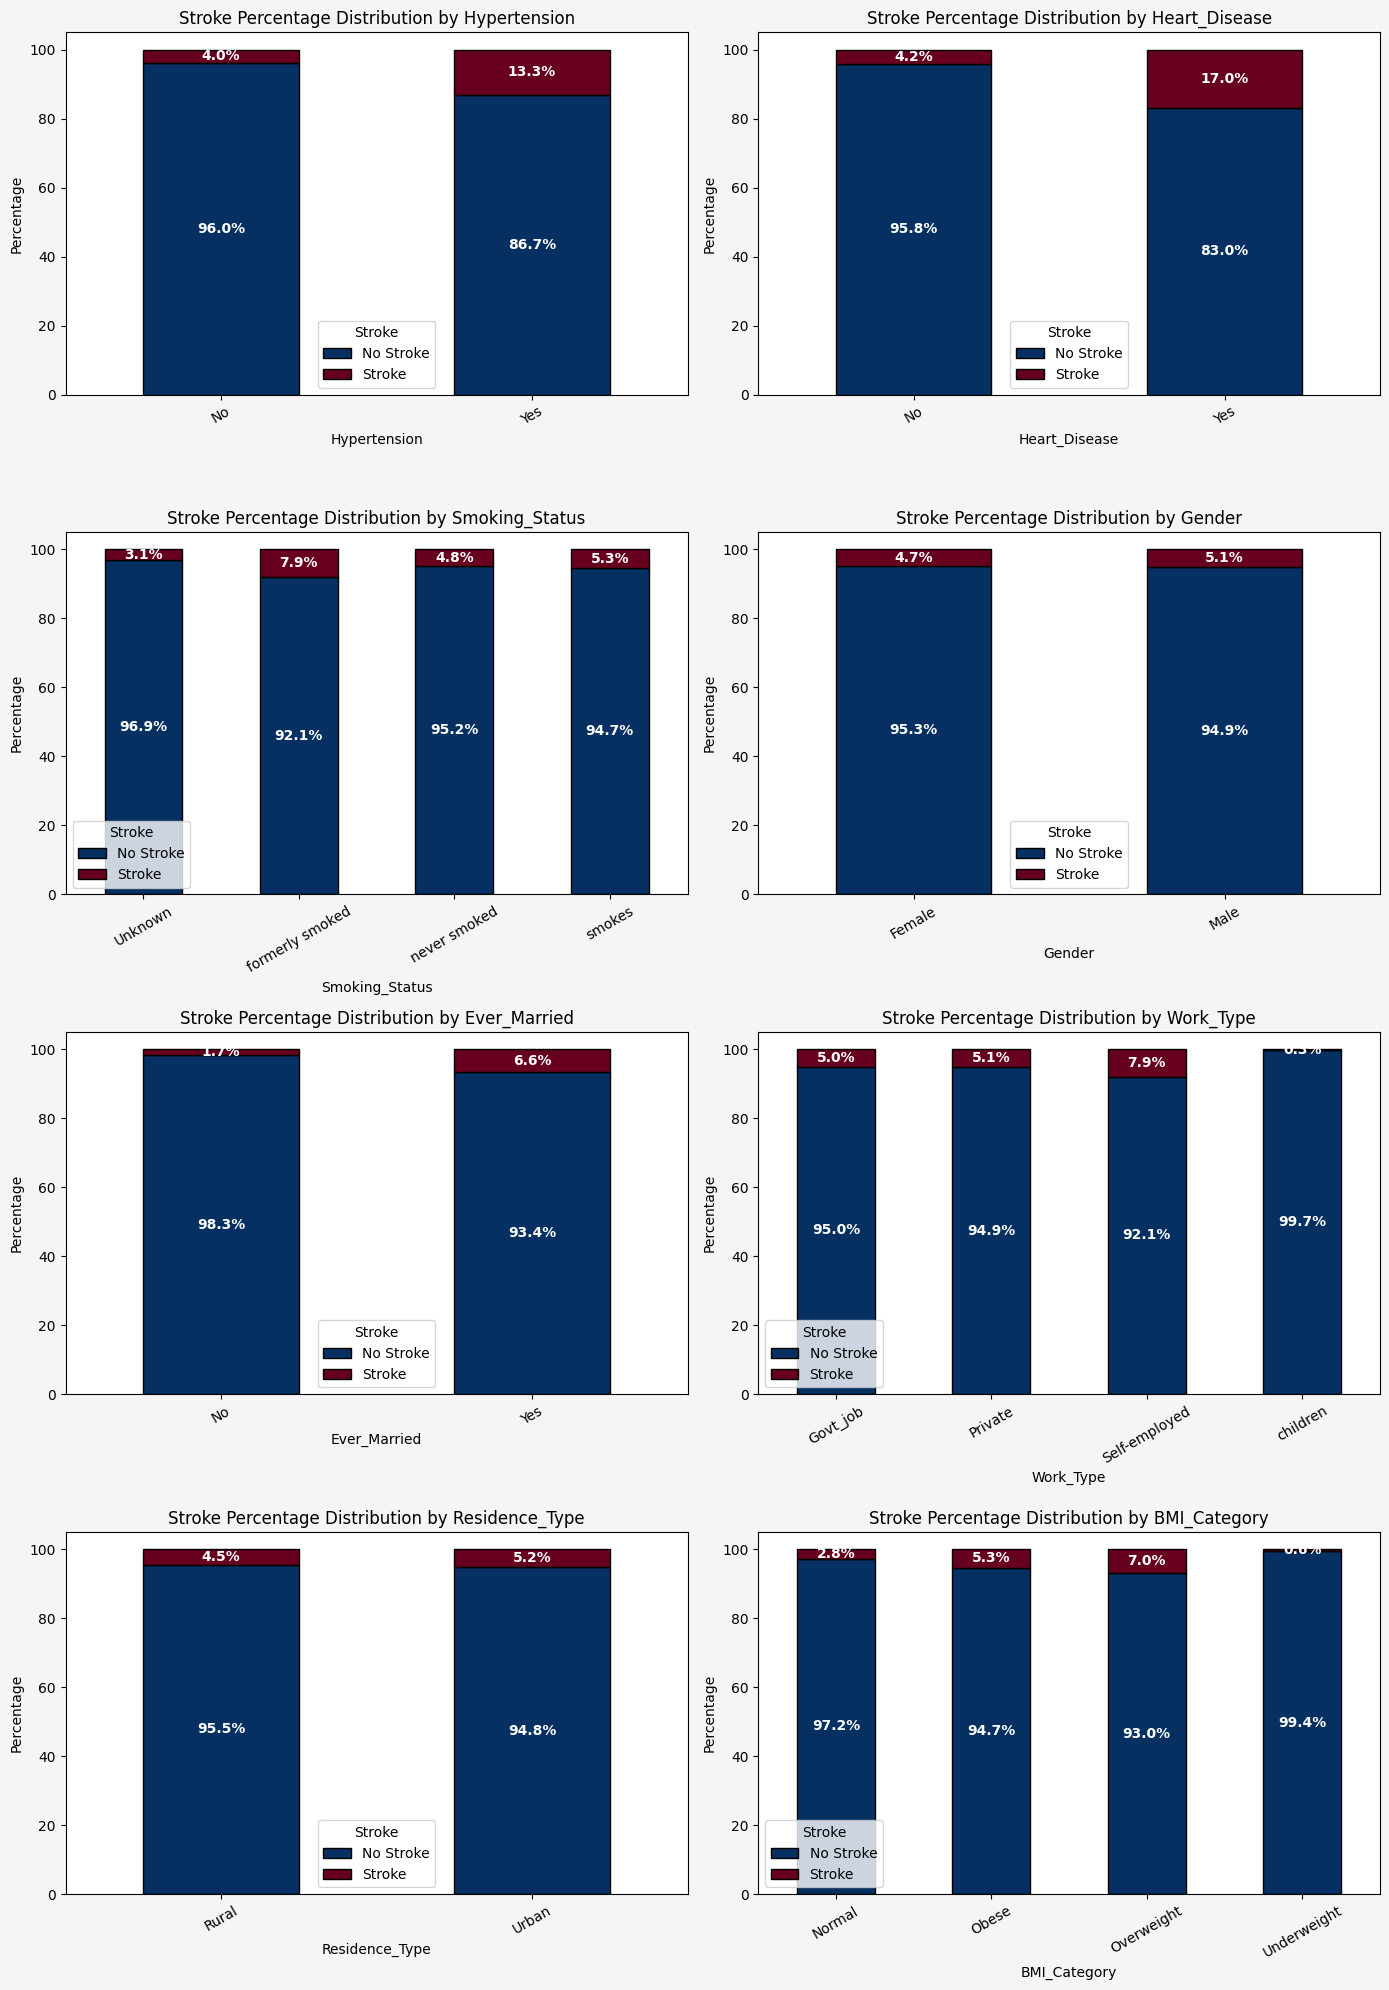

In [33]:
# We can also use a stacked barplot approach, so we can visualize differences in each subcategory even easier
# Now, both the percentage of stroke/no-stroke is goind to be visible in each subclass bar, for each feature
# List of categorical variables to test (The same as before)
categorical_vars = ["Hypertension", "Heart_Disease", "Smoking_Status", "Gender", "Ever_Married", "Work_Type", "Residence_Type", "BMI_Category"]

# Define number of rows and columns (2 plots per row)
num_vars = len(categorical_vars)
num_cols = 2  # Two plots per row
num_rows = (num_vars // num_cols) + (num_vars % num_cols > 0)  # Calculate required rows

# Create figure with larger size
plt.figure(figsize=(14, num_rows * 5), facecolor="whitesmoke")

for i, var in enumerate(categorical_vars, 1):
    plt.subplot(num_rows, num_cols, i)  # Adjust grid layout

    # Compute stroke percentages within each category
    category_counts = main_df.groupby(var)["Stroke"].value_counts(normalize=True).unstack() * 100  # Convert to percentage

    # Create stacked barplot
    ax = category_counts.plot(kind="bar", stacked=True, colormap="RdBu_r", edgecolor="black", ax=plt.gca())

    # Add percentage labels inside the bars
    for p in ax.patches:
        height = p.get_height()
        if height > 0:  # Avoid labeling zero-height bars
            ax.annotate(f"{height:.1f}%", 
                        (p.get_x() + p.get_width() / 2, p.get_y() + height / 2), 
                        ha='center', va='center', fontsize=10, color='white', fontweight='bold')

    # Titles and labels
    plt.title(f"Stroke Percentage Distribution by {var}")
    plt.xlabel(var)
    plt.ylabel("Percentage")
    plt.xticks(rotation=30)  # Rotate labels for readability
    plt.legend(["No Stroke", "Stroke"], title="Stroke")

plt.tight_layout()
plt.show()


### The similar to before results, are now even easier to observe. There seem to be interesting comparative differences of the stroke/no-stroke percentages, among some of the feature subclasses.
### Of course we need to verify the statistical significance of these differences, and the appropriate test here is once again the Chi-Squared Test for Independence.
### As I have done so far, I am going to use a level of significance a = 0.05, which is a basic rule of thumb.
### This is not binding, however, and it should be noted that in this level of significance, tests that return p-values between 0.04 and 0.05 need to be handled carefully, as they are prone to false positives. P-Values below 0.04 are "safer" in this matter, but of course we can control against false positives even more, by lowering the significance even further, if needed.

In [34]:
# I will perform Chi-Squared Tests for all the categorical variables
# Results will be visualized in a final dataframe, in order of statistical significance returned (p-values)

# Defining the same categorical variables to be used
categorical_vars = ["Smoking_Status", "Hypertension", "Heart_Disease", "Ever_Married", "Residence_Type", "Work_Type", "Gender", "BMI_Category"]

# To store the test results
chi_square_results = []

# Run Chi-Square test for each categorical variable
for var in categorical_vars:
    contingency_table = pd.crosstab(main_df["Stroke"], main_df[var])
    chi2_stat, p_value, _, _ = stats.chi2_contingency(contingency_table)
    
    # Determine significance level
    significance = "Significant" if p_value < 0.05 else "Not Significant"
    
    # Append results to list
    chi_square_results.append({"Feature": var, "Chi2-Statistic": chi2_stat, "P-Value": p_value, "Result": significance})

# Convert results to a DataFrame
chi_square_df = pd.DataFrame(chi_square_results)

# Display the results (sorted by P-Value returned by the test)
chi_square_df.sort_values(by="P-Value", ascending=True, ignore_index=True)

,Feature,Chi2-Statistic,P-Value,Result
0,Heart_Disease,89.566847,2.964506e-21,Significant
1,Hypertension,80.864509,2.417364e-19,Significant
2,Ever_Married,57.634965,3.155659e-14,Significant
3,Work_Type,47.830901,2.313433e-10,Significant
4,BMI_Category,40.682593,7.635517e-09,Significant
5,Smoking_Status,28.824559,2.437805e-06,Significant
6,Residence_Type,1.126169,2.885940e-01,Not Significant
7,Gender,0.354576,5.515343e-01,Not Significant


### It is evident that there are indeed statistically significant differences among these subclasses explored.
### We can now try and estimate the feature importance, of all our features, before we move on to the training stage.

###

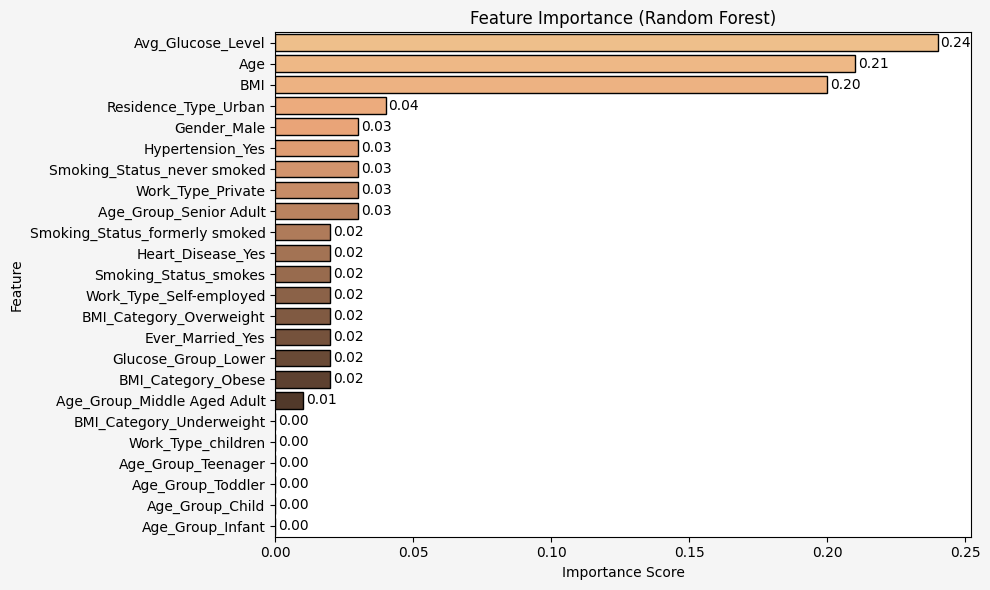

In [35]:
# We can use a Random Forest for feature importance estimation
# This will help us identify which features are more important/strong predictors of stroke occurence
# Prepare data (exclude non-numeric categorical variables for this test)
X = main_df.drop(columns=["Stroke"])
y = main_df["Stroke"]

# Convert categorical variables using one-hot encoding (for numerical analysis)
X = pd.get_dummies(X, drop_first=True)

# Train a simple Random Forest model to estimate feature importance
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# Get feature importances (rounded to 2 decimals)
feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False).round(2)

# Plot feature importance
plt.figure(figsize=(10, 6), facecolor="whitesmoke")
ax = sns.barplot(x=feature_importances, y=feature_importances.index, palette="copper_r", edgecolor="black")

plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")

# Include the count labels for every bar (rounded to 2 decimals)
for x in ax.containers:
    ax.bar_label(x, fmt="%.2f", label_type="edge", padding=2)  # Format labels to 2 decimal places

plt.tight_layout()
plt.show()


###

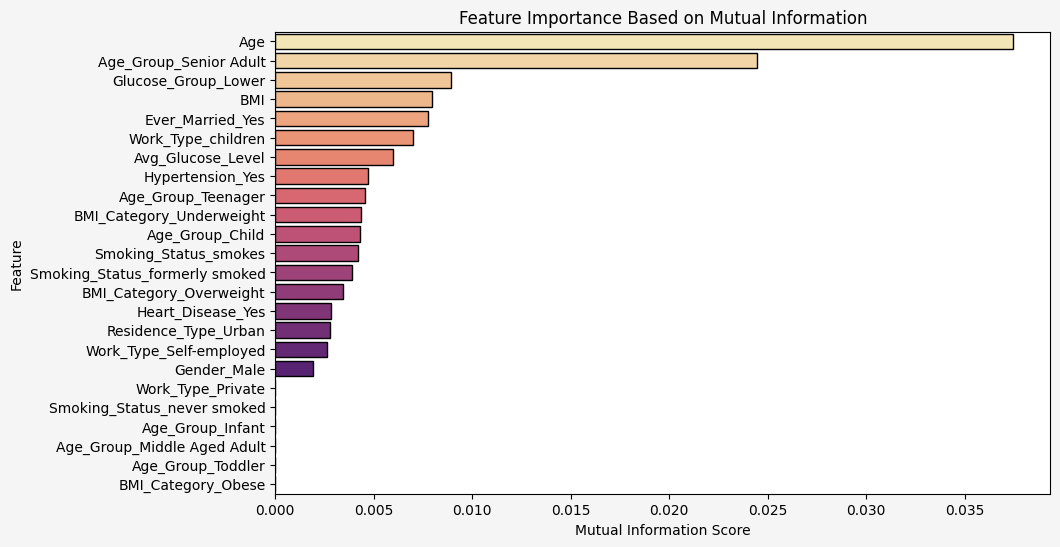

In [36]:
# Another approach is to use a MI (Mutual Information) classification technique.
# Mutual Information (MI) measures how much predictive power each feature has without assuming linearity (useful for non-linear relationships)

# Prepare data (excluding target variable)
X = main_df.drop(columns=["Stroke"])
y = main_df["Stroke"]

# Convert categorical features to numeric using one-hot encoding
X = pd.get_dummies(X, drop_first=True)

# Compute Mutual Information scores
mi_scores = mutual_info_classif(X, y, random_state=42)
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

# Plot MI Scores
plt.figure(figsize=(10, 6), facecolor="whitesmoke")
sns.barplot(x=mi_series, y=mi_series.index, palette="magma_r", edgecolor="black")
plt.title("Feature Importance Based on Mutual Information")
plt.xlabel("Mutual Information Score")
plt.ylabel("Feature")
plt.show()

###

In [37]:
# Another approach still, is to use Recursive Feature Elimination (RFE)
# RFE uses a model (for example Logistic Regression or Random Forest) to recursively eliminate the weakest features.
# Since we implemented a Random Forest above, lets try Logistic Regression now

# Prepare data
X = main_df.drop(columns=["Stroke"])
y = main_df["Stroke"]
X = pd.get_dummies(X, drop_first=True)

# Use Logistic Regression for RFE
model = LogisticRegression(max_iter=1000, random_state=42)
rfe = RFE(model, n_features_to_select=5)  # Select top 5 features
rfe.fit(X, y)

# Show selected features
selected_features = X.columns[rfe.support_]
print("Selected Features:", selected_features)

Selected Features: Index(['Heart_Disease_Yes', 'Age_Group_Child', 'Age_Group_Middle Aged Adult',
       'Age_Group_Senior Adult', 'Glucose_Group_Lower'],
      dtype='object')


###

In [38]:
# We can also use Select-K-Best (using Chi-Squared Test)
# This will selects the K best features based on statistical significance
# Lets see if the results agree with what we have seen so far

# Apply SelectKBest with Chi-Square Test
kbest = SelectKBest(score_func=chi2, k=5)  # Select top 5 features
X_kbest = kbest.fit_transform(X, y)

# Get feature scores
feature_scores = pd.Series(kbest.scores_, index=X.columns).sort_values(ascending=False)
print("Top Features Based on Chi-Square Test:\n", feature_scores.head(10))


Top Features Based on Chi-Square Test:
 Age                               3590.440774
Avg_Glucose_Level                 1713.360448
Age_Group_Senior Adult             201.630789
Heart_Disease_Yes                   87.294416
Hypertension_Yes                    74.732802
Work_Type_children                  31.277408
Ever_Married_Yes                    20.002339
Smoking_Status_formerly smoked      17.361781
Age_Group_Child                     17.138694
BMI                                 16.831658
dtype: float64


###

In [39]:
# One last try would be LASSO Regression (using L1 Regularization)
# LASSO Regression automatically removes features that are not important by shrinking their coefficients to zero

# Train LASSO model
lasso = Lasso(alpha=0.01, random_state=42)
lasso.fit(X, y)

# Get feature importance (non-zero coefficients)
lasso_features = X.columns[lasso.coef_ != 0]
print("Selected Features via LASSO:", lasso_features)

Selected Features via LASSO: Index(['Age', 'Avg_Glucose_Level', 'BMI'], dtype='object')


###

### Examining the results with a final check, we can observe the following:

###

## **Highly Important Features (Appeared in Multiple Methods)**
### These features were consistently selected by Mutual Information, Random Forest, RFE, LASSO, and Chi-Square:

### 1) Age (High importance in all methods)
### 2) Avg_Glucose_Level (Important in RF, MI, and Chi-Square)
### 3) Hypertension (Selected by multiple methods)
### 4) Heart_Disease (Strong statistical significance)
### 5) BMI (Important but slightly lower ranking)

###

## **Features That Can Be Dropped**
### These features had low importance or were redundant:

### 1) Age_Group_Child, Age_Group_Middle Aged Adult, Age_Group_Senior Adult
Redundant with Age (since Age is numerical, keeping these categories is unnecessary)


### 2) Residence_Type
Low importance across all methods.

### 3) Work_Type
While it showed some correlation, it was not consistently important in all methods.


###

## **Conditional Features (Optional Based on Experimentation)**
### These features had moderate importance, so they can be tested in models and dropped if needed:

### 1) Smoking_Status (Moderate importance but could be useful)
### 2) Ever_Married (Somewhat important but lower-ranked)
### 3) Gender (Low impact, but could be retained for testing)

###

## **Final Feature List for Model Training**

### Final Selected Features:
### 1) Age
### 2) Avg_Glucose_Level
### 3) Hypertension
### 4) Heart_Disease
### 5) BMI
### 6) Smoking_Status 
(optional for experimentation)
### 7) Ever_Married 
(optional for experimentation)


###

## Dropped Features:
### 1) Age_Group categories (since Age is numerical)
### 2) Residence_Type (low importance)
### 3) Work_Type (redundant or low impact)
### 4) Gender (can be excluded unless needed)

###

In [40]:
# Now we can prepare and save the dataset
# That way we can load the prepared data to start the third part - model training and validation

# Select the final recommended features for model training
final_features = ["Age", "Avg_Glucose_Level", "Hypertension", "Heart_Disease", "BMI", "Smoking_Status", "Ever_Married"]

# Create a new dataframe with only the selected features and the target variable
model_ready_df = main_df[final_features + ["Stroke"]]

# Save the cleaned dataset for modeling
model_ready_df.to_csv("prepared_stroke_data.csv", index=False)

print("Dataset prepared and saved as 'prepared_stroke_data.csv'.")


Dataset prepared and saved as 'prepared_stroke_data.csv'.


In [41]:
model_ready_df.head()

,Age,Avg_Glucose_Level,Hypertension,Heart_Disease,BMI,Smoking_Status,Ever_Married,Stroke
0,67.0,228.69,No,Yes,36.6,formerly smoked,Yes,1
1,61.0,202.21,No,No,29.2,never smoked,Yes,1
2,80.0,105.92,No,Yes,32.5,never smoked,Yes,1
3,49.0,171.23,No,No,34.4,smokes,Yes,1
4,79.0,174.12,Yes,No,24.0,never smoked,Yes,1


### This concludes the analysis phase.